In [1]:

import numpy as np
import numpy as np
import torch as t
import torch.nn.functional as F
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model_name = "gpt2-medium"  # you can replace 'gpt2-medium' with 'gpt2' if you want the smaller model

# Load model
model = GPT2LMHeadModel.from_pretrained(model_name).to("cuda")

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'left'

C:\Users\wusch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def process_with_avg_prob_embedding(model, logits, attention_mask=None):
    # Ensure model is in evaluation mode
    model.eval()

    device = model.device  # This line captures the device model is on

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(logits.to(device), dim=-1)  # Ensure logits are on the same device

    # Get all possible embeddings from the model
    all_embeddings = model.transformer.wte.weight

    weighted_embeddings = torch.matmul(probabilities, all_embeddings)
    weighted_embeddings = weighted_embeddings.unsqueeze(0)

    hidden_states = weighted_embeddings

    # Pass the repeated averaged embeddings through the model layers
    for block in model.transformer.h:  # Updated loop to iterate through GPT2 blocks
        hidden_states = block(hidden_states)[0]  # Taking the first output as the transformed hidden state

    # Convert the final hidden states back to logits
    logits_output = model.transformer.ln_f(hidden_states)  # Apply final layer norm
    logits_output = model.transformer.wte.weight.matmul(logits_output.transpose(1, 2)).transpose(1, 2)  # Convert back to logits

    # Return the logits
    return logits_output.squeeze(0)  # Removing the batch dimension

In [3]:
def create_logit_tensor_from_prompt(prompt: str, tokenizer):
    """
    Given a prompt, tokenizes the prompt using the provided tokenizer and returns a logit tensor 
    where positions corresponding to the tokens have a value of 0 and all other positions have a value of -inf.
    """
    
    # Tokenize the prompt
    tokenized_output = tokenizer.encode(prompt, return_tensors="pt").squeeze()
    
    # Check if tokenized_output is a scalar
    if len(tokenized_output.shape) == 0:
        tokenized_output = tokenized_output.unsqueeze(0)  # Convert scalar to 1D tensor
    
    tokenized_output = tokenized_output.tolist()
    
    vocab_size = tokenizer.vocab_size
    tensor = t.full((len(tokenized_output), vocab_size), float('-inf'))
    
    for idx, token in enumerate(tokenized_output):
        tensor[idx, token] = 0.0
        
    return tensor


In [4]:

def kl_divergence_from_logits(logits1, logits2):
    """
    Computes the KL divergence between two distributions represented by logits.
    
    Args:
    - logits1 (list or torch.Tensor): Logits for the first distribution.
    - logits2 (list or torch.Tensor): Logits for the second distribution.
    
    Returns:
    - KL divergence (torch.Tensor): KL(logits1 || logits2)
    """

    # Convert lists to tensors
    logits1 = torch.tensor(logits1, dtype=torch.float)
    logits2 = torch.tensor(logits2, dtype=torch.float)

    # Convert logits to probabilities
    probs1 = F.softmax(logits1, dim=-1)
    probs2 = F.softmax(logits2, dim=-1)

    # Convert to tensors
    p_tensor = torch.tensor(probs1, dtype=torch.float32)
    q_tensor = torch.tensor(probs2, dtype=torch.float32)

    # Convert to log-probabilities
    log_q_tensor = torch.log(q_tensor)

    # Compute KL divergence using PyTorch
    kl_div_value = F.kl_div(log_q_tensor.unsqueeze(0), p_tensor.unsqueeze(0), reduction='batchmean').item()

    return kl_div_value

In [5]:
def generate_strings(N, M, model, tokenizer):
    """
    Generate N strings each with M tokens using GPT-2.

    Args:
    - N (int): Number of strings to generate.
    - M (int): Number of tokens per string.
    - model (GPT2LMHeadModel): Pre-trained GPT-2 model.
    - tokenizer (GPT2Tokenizer): Tokenizer for GPT-2.

    Returns:
    - List of N strings.
    """

    generated_strings = []
    
    # Set model in evaluation mode
    model.eval()

    # If bos_token is not available in the tokenizer, use a random token (e.g., "a")
    input_token = tokenizer.bos_token or "a"
    input_ids = tokenizer.encode(input_token, return_tensors="pt").to("cuda")

    while len(generated_strings)!=N:
        with torch.no_grad():  # Disable gradient calculations
            output = model.generate(input_ids, max_length=M+1, do_sample=True, pad_token_id=tokenizer.eos_token_id, num_return_sequences=1)
        
        # Convert the generated tokens to a string
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        if len(tokenizer.encode(generated_text)) == M:
            generated_strings.append(generated_text)
    

    return generated_strings

In [6]:
def run_experiments(model, tokenizer, numbers_of_completions, lengths_of_completions, N_samples):
    # Set up tensor sizes based on the lengths of numbers_of_completions and lengths_of_completions lists
    kl_divs_linearity = torch.zeros((len(numbers_of_completions), len(lengths_of_completions), N_samples))
    avg_kl_divs = torch.zeros((len(numbers_of_completions), len(lengths_of_completions), N_samples))
    all_kl_divs = [[] for _ in numbers_of_completions]
    std_kl_divs = torch.zeros((len(numbers_of_completions), len(lengths_of_completions), N_samples))

    # Iterate over each value in numbers_of_completions and lengths_of_completions
    for N_idx, N in enumerate(numbers_of_completions):
        for M_idx, M in enumerate(lengths_of_completions):
            for O in range(N_samples):
                strings = generate_strings(N, M, model, tokenizer)
                logits=[create_logit_tensor_from_prompt(s,tokenizer) for s in strings]
                average_input_logits = torch.log(torch.mean(torch.stack([torch.nn.functional.softmax(logit, dim=-1) for logit in logits]), dim=0))

                output_logits=[process_with_avg_prob_embedding(model, l) for l in logits]
                output_logits_averagred_before_forwardpass=process_with_avg_prob_embedding(model, average_input_logits)
                output_logits_averagred_after_forwardpass=torch.stack(output_logits).mean(dim=0)

                kl_between_members=[]
                for i in range(len(output_logits)):
                    for j in range(len(output_logits)):
                        if i!=j:
                            div=kl_divergence_from_logits(output_logits[i][-1], output_logits[j][-1])
                            kl_between_members.append(float(div))
                            all_kl_divs[N_idx].append(float(div))
                kl_on_linearity=kl_divergence_from_logits(output_logits_averagred_before_forwardpass[-1], output_logits_averagred_after_forwardpass[-1])
                
                kl_divs_linearity[N_idx, M_idx, O] = kl_on_linearity
                avg_kl_divs[N_idx, M_idx, O] = np.mean(kl_between_members)
                std_kl_divs[N_idx, M_idx, O] = np.std(kl_between_members)
    return kl_divs_linearity, avg_kl_divs, std_kl_divs, all_kl_divs

In [71]:
numbers_of_completions=[2,3,5,10,20]
lengths_of_completions=[4,10]
samples=5

In [72]:

kl_divs_linearity,avg_kl_divs,std_kl_divs, all_kl_divs=run_experiments(model, tokenizer,numbers_of_completions,lengths_of_completions,samples)


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
C:\Users\wusch\AppData\Local\Temp\ipykernel_37044\903288071.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits1 = torch.tensor(logits1, dtype=torch.float)
C:\Users\wusch\AppData\Local\Temp\ipykernel_37044\903288071.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits2 = torch.tensor(logits2, dtype=torch.float)
C:\Users\wusch\AppData

In [74]:
nonlinarity=t.mean(kl_divs_linearity,dim=2)
avg_normal=t.mean(avg_kl_divs,dim=2)
result_tensor = nonlinarity / avg_normal

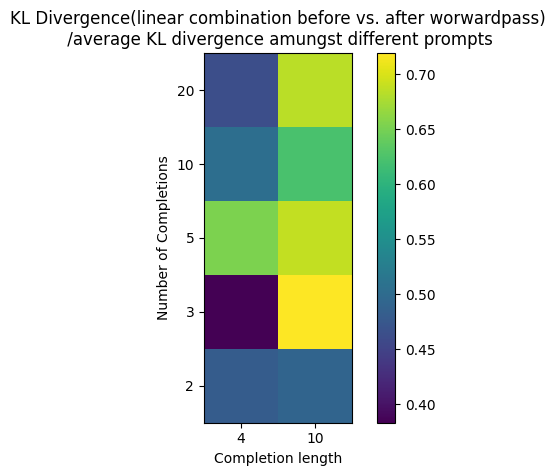

In [75]:
import matplotlib.pyplot as plt

plt.imshow(result_tensor, origin='lower')
plt.colorbar()  # Add a colorbar

# Add axis descriptions
plt.ylabel('Number of Completions')
plt.xlabel('Completion length')
plt.title('KL Divergence(linear combination before vs. after worwardpass)\n /average KL divergence amungst different prompts')

# Adjust the ticks
plt.xticks(range(result_tensor.shape[1]), [str(i) for i in lengths_of_completions])
plt.yticks(range(result_tensor.shape[0]), [str(i) for i in numbers_of_completions])
#y_ticks = plt.yticks()[0]  # Get current ticks
#plt.yticks(y_ticks, y_ticks + 1)  # Adjust ticks to start from 1

plt.show()


In [76]:
y_1_list=all_kl_divs
y_2_list=[kl_divs_linearity[i].flatten().numpy().tolist() for i in range(len(kl_divs_linearity))]

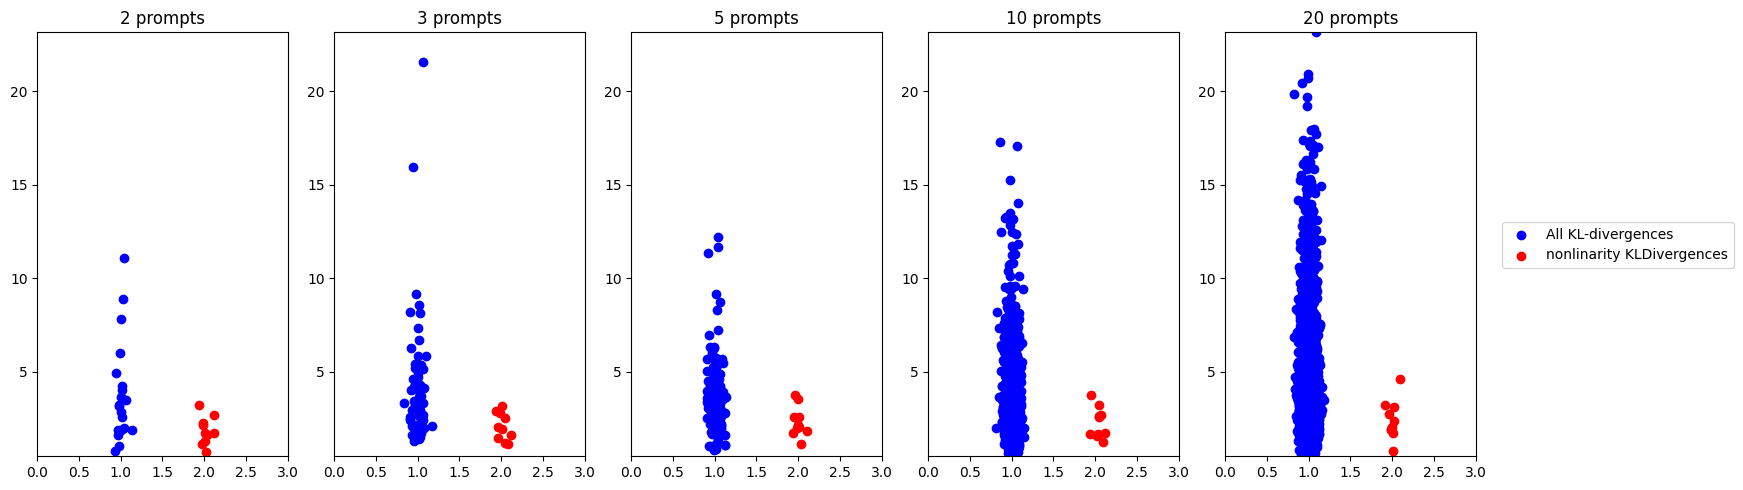

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def jittered_scatter(y1, y2, ax, jitter_amount=0.05):
    # Generate jittered x values
    x1 = np.random.normal(1, jitter_amount, size=len(y1))
    x2 = np.random.normal(2, jitter_amount, size=len(y2))
    
    ax.scatter(x1, y1, label='All KL-divergences', color='blue')
    ax.scatter(x2, y2, label='nonlinarity KLDivergences', color='red')
    ax.set_xlim(0, 3)

# Sample data
# [ ... your data loading code ... ]

# Determine global y-limits
global_min = min(np.min(y) for y in y_1_list + y_2_list)
global_max = max(np.max(y) for y in y_1_list + y_2_list)

# Plotting
fig, ax_tiple = plt.subplots(1, len(y_1_list), figsize=(15, 5))  # Change (1, 2) for the number of plots you want
title_list = [str(i)+" prompts" for i in numbers_of_completions]

for y1, y2, ax, title in zip(y_1_list, y_2_list, ax_tiple, title_list):
    jittered_scatter(y1, y2, ax)
    ax.set_title(title)
    ax.set_ylim(global_min, global_max)  # Set the same y-scale for all subplots

# Set one global legend outside the plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


In [7]:
def distribution_interpolation(logit_1, logit_2, interpol_lambda):
    prob_1 = F.softmax(logit_1, dim=-1)
    prob_2 = F.softmax(logit_2, dim=-1)
    
    interpol_prob = prob_1 * interpol_lambda + prob_2 * (1 - interpol_lambda)
    
    return torch.log(interpol_prob)

In [8]:
def interpolation_experiment(model, tokenizer, lengths_of_completions, N_samples):
    # Set up tensor sizes based on the lengths of numbers_of_completions and lengths_of_completions lists
    destribution_list=[]

    strings = generate_strings(2, lengths_of_completions, model, tokenizer)
    logits=[create_logit_tensor_from_prompt(s,tokenizer) for s in strings]

    for interpol_lambda in torch.linspace(0,1,N_samples):
        combined_logits=distribution_interpolation(logits[0], logits[1], interpol_lambda)
        destribution_list.append(process_with_avg_prob_embedding(model, combined_logits)[-1])
    return destribution_list, strings


In [79]:
destribution_list,strings=interpolation_experiment(model, tokenizer, 5, 100)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [80]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

def plot_topN_across_distributions(distribution_list, N, tokenizer):
    # Convert list to tensor if it's not
    if not isinstance(distribution_list[0], torch.Tensor):
        distribution_list = [torch.tensor(d) for d in distribution_list]
    
    # Create figure and axis objects
    fig, ax = plt.subplots()
    
    # Get the first, middle, and last logits
    first_logits = distribution_list[0]
    middle_logits = distribution_list[len(distribution_list) // 2]
    last_logits = distribution_list[-1]

    # Calculate the top N indices for first, middle, and last logits
    _, top_indices_first = first_logits.topk(N)
    _, top_indices_middle = middle_logits.topk(N)
    _, top_indices_last = last_logits.topk(N)
    
    # Define color scheme
    colors_first = ['red'] * len(top_indices_first)
    colors_middle = ['green'] * len(top_indices_middle)
    colors_last = ['blue'] * len(top_indices_last)
    
    # Merge top indices and colors
    top_indices = torch.cat((top_indices_first, top_indices_middle, top_indices_last))
    colors = colors_first + colors_middle + colors_last

    # For each index in top_indices, extract its probability from each distribution
    for index, color in zip(top_indices, colors):
        probs = []
        for logits in distribution_list:
            softmax_probs = F.softmax(logits, dim=-1)
            if index.item() < softmax_probs.size(0):  # Check if index is valid for this logits tensor
                probs.append(softmax_probs[index].item())
            else:
                probs.append(0)  # Or add a default value if index is out of bounds
        ax.plot(torch.linspace(0, 1, len(distribution_list)), probs, label=tokenizer.decode(index.item()), color=color)

    # Plot settings
    ax.set_xlabel('Lambda')
    ax.set_ylabel('Probability')
    ax.set_title('Top N Probabilities across List')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.text(0.05, -0.05, strings[0], ha='left', va='bottom', fontsize=12)
    fig.text(0.95, -0.05, strings[1], ha='right', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

# Sample usage:
# tokenizer = some_defined_tokenizer
# plot_topN_across_distributions(distribution_list, N=5, tokenizer=tokenizer)


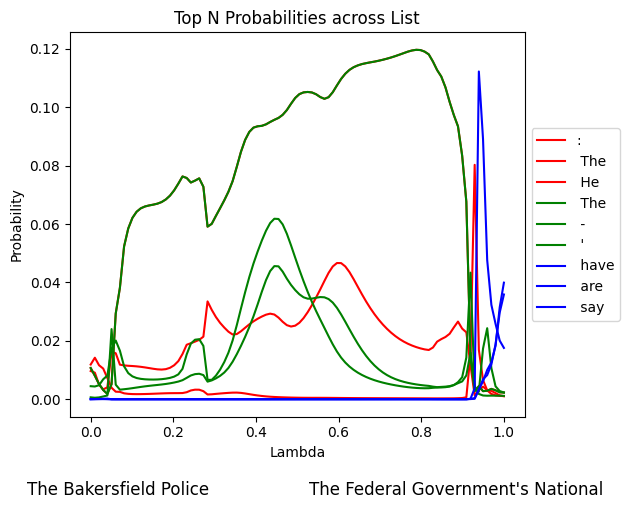

In [81]:
plot_topN_across_distributions(destribution_list,3,tokenizer)

In [12]:
print(strings[0])
print(strings[1])

When our first kids became
The latest batch of leaked


In [68]:
strings = generate_strings(1, 10, model, tokenizer)
logits=[create_logit_tensor_from_prompt(s,tokenizer) for s in strings]
logits_out=process_with_avg_prob_embedding(model, logits[0])
logits_out=F.softmax(logits_out[-1], dim=-1)
print(strings[0])
for tol in t.topk(logits_out,4).indices:
    print(tokenizer.decode(tol))
    print(float(logits_out[tol]))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


New Zealand's National Party is making a bid to
 new
0.12487737834453583
 a
0.0452217236161232
 New
0.03202006593346596
 '
0.02901790663599968


In [63]:
t.sum(logits_out)

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [52]:
float(logits_out[-1][10])

-70.60680389404297

In [58]:
t.exp(t.max(logits_out[-1]))


tensor(1.3472e-29, device='cuda:0', grad_fn=<ExpBackward0>)

In [158]:
logits_out[-1]

tensor([-76.9714, -78.4607, -82.4391,  ..., -86.6602, -85.6983, -79.2247],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [161]:
tokenizer.decode(t.argmax(logits_out[-1]).item())

' have'

In [178]:
create_logit_tensor_from_prompt("heki",tokenizer)

AttributeError: 'Tensor' object has no attribute 'full'

In [172]:
t.topk(logits_out[-1],4).indices

tensor([262,  11, 287, 510], device='cuda:0')